<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Simulation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Spatial Simulation with Sequential Gaussian Simulation (SGSIM)** with a 2D map example.

* sequential Gaussian simulation is a common geostatistical method for calculating spatial models with an appropriate level of heterogeneity

**YouTube Lecture**: check out my lecture on [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). For your convenience here's a summary of salient points.

#### Estimation vs. Simulation

Let's start by comparing spatial estimation and simulation,

**Estimation**: 

* honors local data 
* locally accurate, primary goal of estimation is 1 estimate! 
* too smooth, appropriate for visualizing trends 
* too smooth, inappropriate for flow simulation 
* one model, no assessment of global uncertainty

Let's visualize a population, sample and estimation model. Note the estimation model is too smooth, too much spatial continuity and too little variance.

<figure style="text-align: center;">
  <img src="_static/simulation/estimation.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;">Spatial dataset, truth, and an estimation model (left), estimation model and truth histograms (center) and experimental variograms (right).</figcaption>
</figure>

**Simulation**: 

* honors local data 
* sacrifices local accuracy, reproduces histogram 
* honors spatial variability, appropriate for flow simulation 
* alternative realizations, change random number seed 
* many models (realizations), assessment of global uncertainty

Now let's visualize a population, sample and simulation model. Note the simulated realizations are locally less accurate, but are not too smooth, the spatial continuity and variance are correct.

<figure style="text-align: center;">
  <img src="_static/simulation/simulation.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;">Spatial dataset, truth, and an simulation model (left), simulation model and truth histograms (center) and experimental variograms (right) for two realizations (above and below).</figcaption>
</figure>

Note with estimation we calculate one model, and with simulation we calculate many realizations to represent uncertainty,

<figure style="text-align: center;">
  <img src="_static/simulation/simulations_temp.png" style="display: block; margin: 0 auto; width: 100%;">
  <figcaption style="text-align: center;">Spatial data section (left), and truth, estimation and simulations models (right).</figcaption>
</figure>

Now let's explain the concept of spatial simulation.

#### Spatial Simulation

This method is critical for:

1. Prediction away from wells, e.g. pre-drill assessments, with uncertainty 
2. Spatial uncertainty modeling.
3. Heterogeneity realizations ready for application to the transfer function.

#### Sequential Gaussian Simulation

A simulation method to calculate realizations for spatial models based on the following principles,

*  **Sequential** - adding the previously simulated values to the data to ensure the covariance is correct between the simulated values

*  **Gaussian** - transformation to Gaussian space so that the local distributions of uncertainty are known given the kriging mean and kriging variance, and the global distribution is reproduced after back-transformation to the original distribution

*  **Simulation** - with Monte Carlo simulation from the local distributions to add in the missing variance and to calculate multiple, equiprobable realizations. The random seed determines the individual Monte Carlo simulations along with the random path for the sequential simulation.

Here are all the steps for sequential Gaussian simulation,

1. Establish grid network and coordinate system, flatten the system including flattening folds and restoring faults 

<figure style="text-align: center;">
  <img src="_static/simulation/sim1.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Original data and grid (above) and flattened grid (below).</figcaption>
</figure>

2. Assign data to the grid, account for scale change from data to model grid cells 

<figure style="text-align: center;">
  <img src="_static/simulation/sim2.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Original data and grid (above) and flattened grid with data assigned to grid cells (below).</figcaption>
</figure>

3. Transform data to Gaussian space, Gaussian anamorphosis applied to original data distribution

<figure style="text-align: center;">
  <img src="_static/simulation/sim3.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Distribution and flattened grid with data assigned to grid cells transformed to Gaussian with a mean of 0.0 and variance of 1.0.</figcaption>
</figure>

4. Calculate and model the variogram of the Gaussian transformed data

<figure style="text-align: center;">
  <img src="_static/simulation/sim4.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Distribution and flattened grid with data assigned to grid cells transformed to Gaussian with variogram calculated and modeled.</figcaption>
</figure>

5. Determine a random path through all of the grid nodes, at each node:

<figure style="text-align: center;">
  <img src="_static/simulation/sim5.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Flattened grid with data assigned to grid cells transformed to Gaussian with random path over cell without data.</figcaption>
</figure>
 
* find nearby data and previously simulated grid nodes
  
* construct the conditional distribution by kriging, mean as kriging estimate and variance as kriging variance 

<figure style="text-align: center;">
  <img src="_static/simulation/sim6.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Flattened grid with data assigned to grid cells transformed to Gaussian with random path over cell without data, and simple kriging to calculate the local distribution of uncertainty at the first location on the random path.</figcaption>
</figure>

* Monte Carlo simulate a realization from the conditional distribution 

<figure style="text-align: center;">
  <img src="_static/simulation/sim7.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Flattened grid with data assigned to grid cells transformed to Gaussian with random path over cell without data, and Monte Carlo simulation from the kriging-derived local distribution of uncertainty.</figcaption>
</figure>

* assign the simulated value to the grid as data

<figure style="text-align: center;">
  <img src="_static/simulation/sim8.png" style="display: block; margin: 0 auto; width: 80%;">
  <figcaption style="text-align: center;">Flattened grid with data assigned to grid cells transformed to Gaussian with random path over cell without data, and Monte Carlo simulation from the kriging-derived local distribution of uncertainty assigned as data.</figcaption>
</figure>
      
7. Check realization (could also check after back transform). Does the realization in Gaussian space honor,

* data at the data locations? 

* honor the histogram, $N\left[0,1\right]$ standard normal with a mean of zero and a variance of one? 

* and honor the variogram? 

7. Back-transform the simulated values from Gaussian space to the original data distribution
   
8. Restore to the original framework, including adding back the folds and faults

9. Check that the realization honors,

* geological concepts? 

* geophysical data?  

* historical production data?

10. Calculate multiple realizations by repeating steps 5 through 9

Here are the critical steps of the sequential Gaussian simulation algorithm only, 

1. Transform the data to Gaussian with a mean of 0.0 and variance of 1.0 (known as standard normal)

2. Assign a random path over the model grid, at each grid location sequentially simulation (apply kriging to calculate the local CDF, then Monte Carlo simulate a local realization, and assign the local realization to the data)

3. Back-transform the simulated values to the original data distribution

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms.

In [3]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill): # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    plt.plot(lags_min,gmod_min,color = 'red',label = 'Input Major Model')
    plt.plot([0,2000],[sill,sill],color = 'black',label = 'Input Minor Model')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Check Directional ' + feature + ' Variogram')
    else: 
        plt.title('Check Omnidirectional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    add_grid()

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

* By setting unconditional to True the data are shifted well outside the area of interest and are only used for the target reference distribution

In [5]:
unconditional = False
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df = df.drop(['index','Unnamed: 0','AI'],axis=1)          # remove extra columns in DataFrame
df['logPerm'] = np.log(df['Perm'].values)                 # calculate the log of permeability
if unconditional == True:
    df['X'] = df['X'] + 9999999.9                         # move the data outside the model, just use the distributions as a reference to constrain the simulated distributions
df.head()                                                 # DataFrame summary

,X,Y,Facies,Porosity,Perm,logPerm
0,360.0,839.0,1.0,0.162925,343.726416,5.839846
1,370.0,529.0,1.0,0.151700,261.673801,5.567099
2,750.0,189.0,1.0,0.138428,10.960150,2.394266
3,300.0,600.0,1.0,0.182676,931.189014,6.836462
4,680.0,859.0,1.0,0.139132,15.031775,2.710166


#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test of 3 realizations.

* look at the realizations and check the histogram and variograms

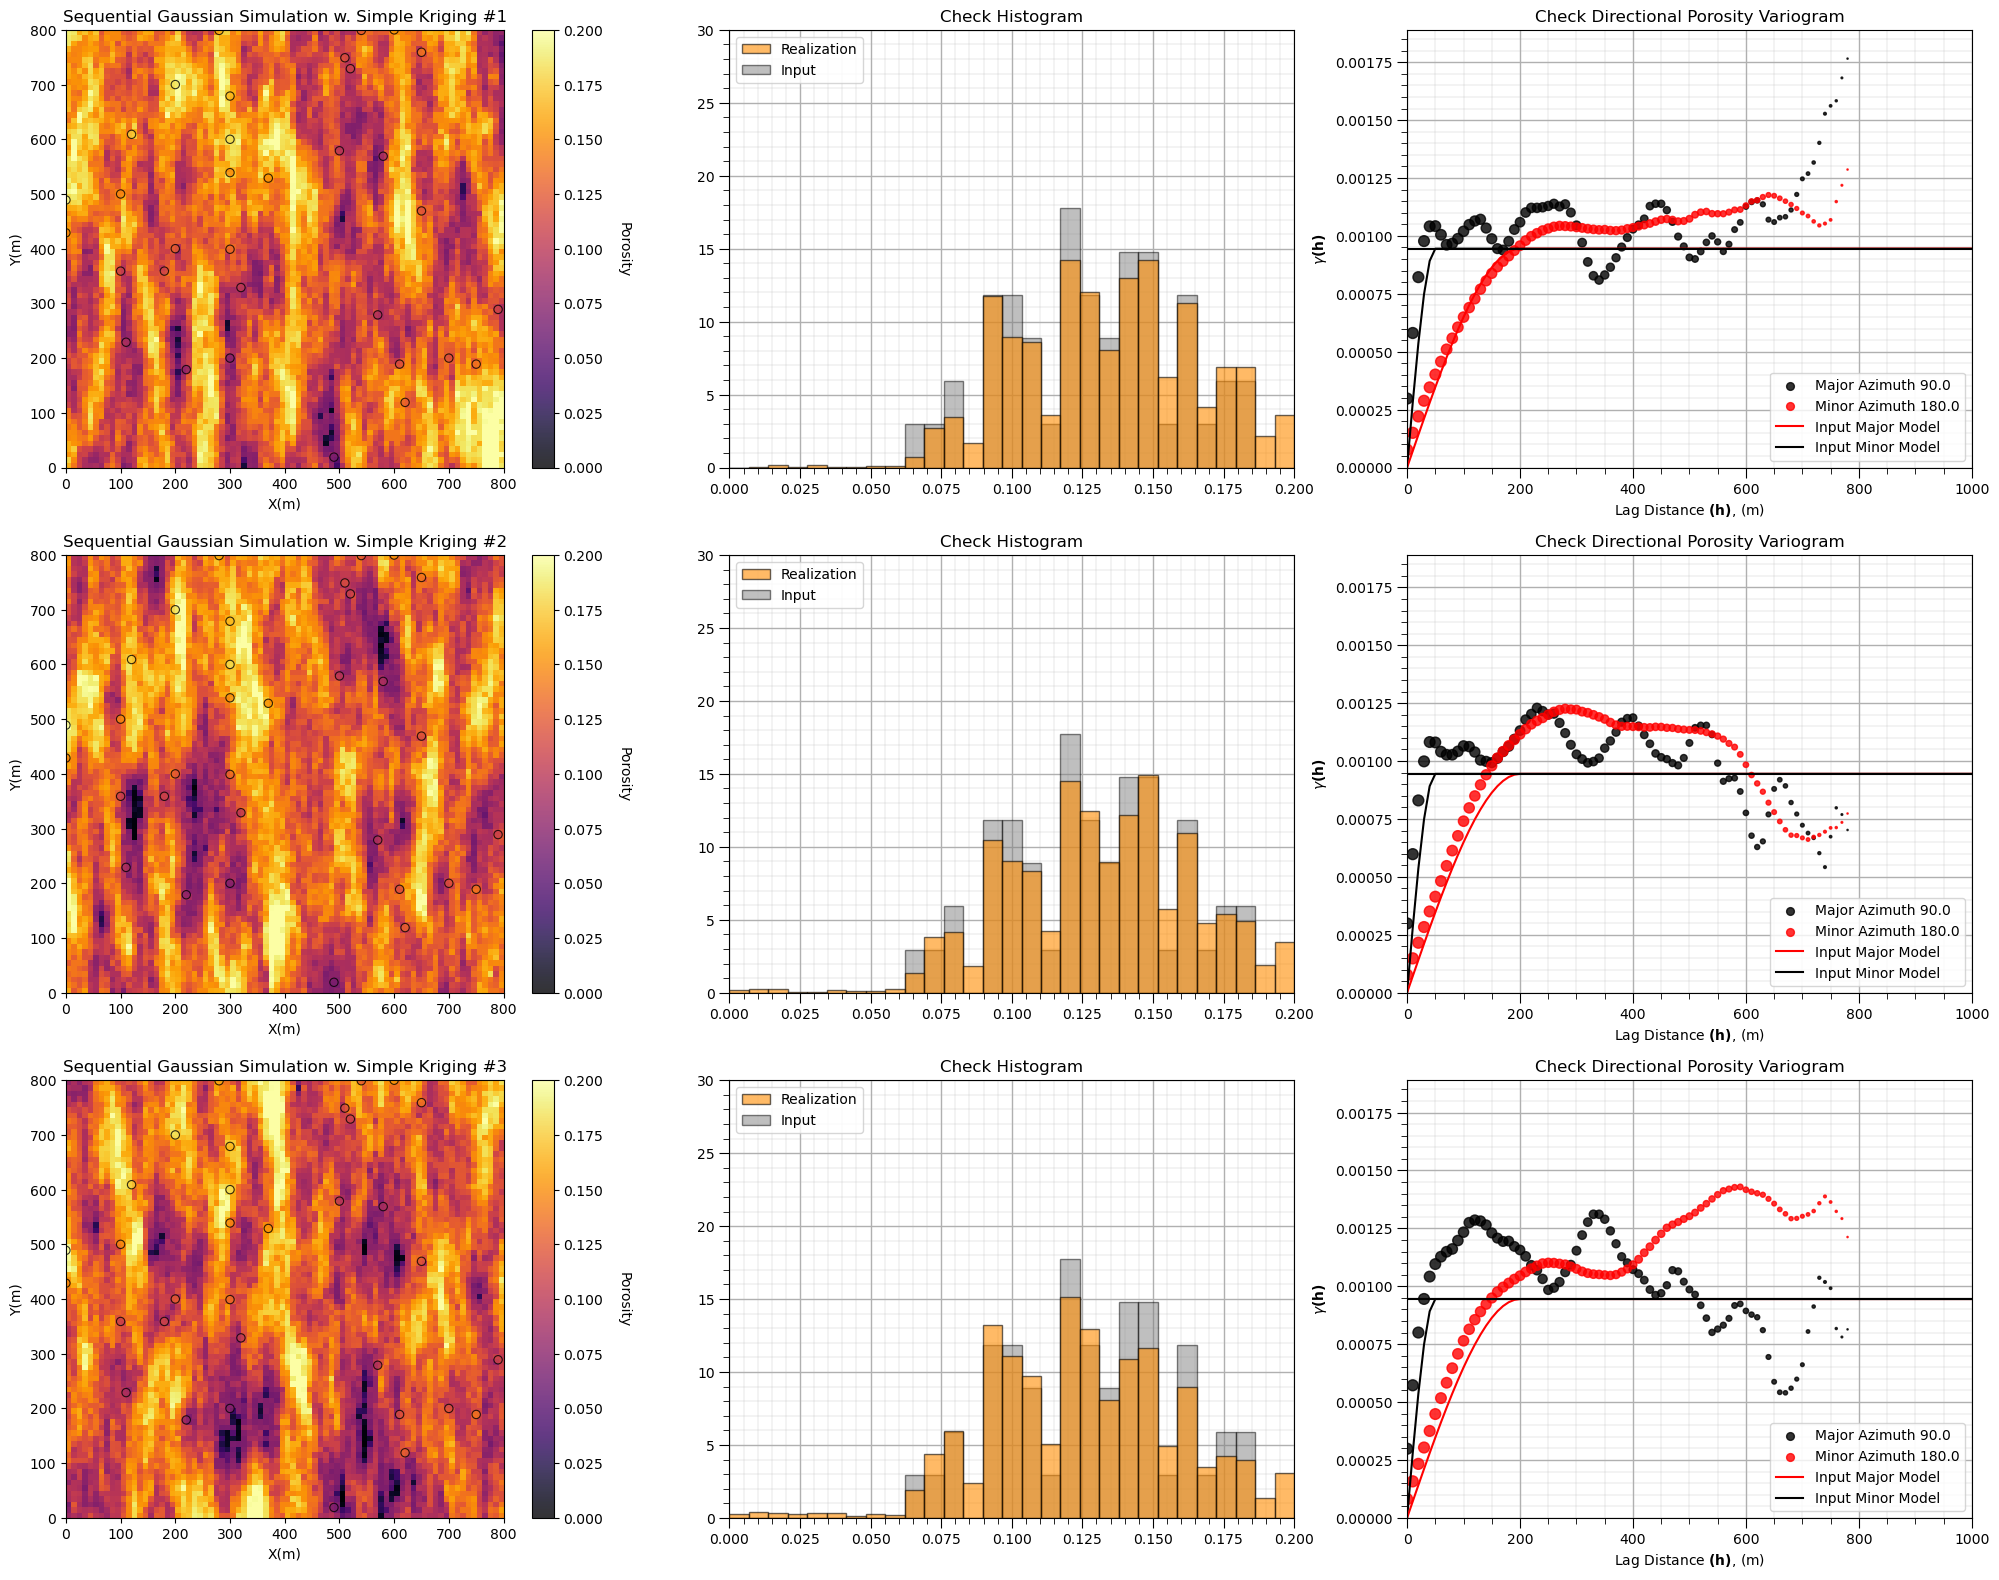

In [6]:
%%capture --no-display                                                                

zmin = 0.00; zmax = 0.20                                  # feature min and max values 
nx = 80; ny = 80; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1 # grid specification
nreal = 3                                                 # number of realizations
ndmin = 0; ndmax = 20                                     # number of data for each kriging system
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999
sill = np.std(df['Porosity'].values)*np.std(df['Porosity'].values)

sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=zmin,zmax=zmax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=nreal,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=1,nmult=3,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

xmin = xmn-xsiz/2; xmax = nx*xsiz + xmin; ymin = ymn-ysiz/2; ymax = ny*ysiz + ymin; cmap = plt.cm.inferno # plotting parameters

for isim in range(0,nreal):
    plt.subplot(nreal,3,1 + isim*3)                                          # plot the results
    GSLIB.locpix_st(sim_sk[isim],xmin,xmax,ymin,ymax,xsiz,zmin,zmax,df,'X','Y','Porosity','Sequential Gaussian Simulation w. Simple Kriging #' + str(isim+1),'X(m)','Y(m)','Porosity',cmap)
    
    lags, gamma_x, npps_x = geostats.gam(sim_sk[isim],-9999.9,9999.9,xsiz,ysiz,ixd=1,iyd=0,nlag=100,isill=0)
    lags, gamma_y, npps_y = geostats.gam(sim_sk[isim],-9999.9,9999.9,xsiz,ysiz,ixd=0,iyd=1,nlag=100,isill=0)

    plt.subplot(nreal,3,2 + isim*3)
    plt.hist(sim_sk[isim].flatten(),bins=np.linspace(zmin,zmax,30),density=True,color='darkorange',alpha=0.6,edgecolor='black',zorder=10,label='Realization')
    plt.hist(df['Porosity'].values,bins=np.linspace(zmin,zmax,30),density=True,color='grey',alpha=0.5,edgecolor='black',zorder=1,label='Input')
    plt.legend(loc='upper left'); add_grid()
    plt.xlim([zmin,zmax]); plt.ylim([0,30]); plt.title('Check Histogram'); add_grid()
    
    plt.subplot(nreal,3,3 + isim*3)
    vario_plot = vario
    vario_plot.update({"cc1":sill})
    vargplot('Porosity',lags,gamma_x,gamma_y,npps_x,npps_y,vario_plot,azi=90.0,atol=22.5,sill=sill)     # plot the variogram
    plt.xlim([0,1000]); plt.ylim([0.0,sill*2.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of sequential Gaussian simulation to calculate spatial heterogeneity realizations that honor the data, histogram and variogram. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)